<a href="https://colab.research.google.com/github/golki007/Nifty50_ML_Portfolio/blob/main/Nifty50_ML_Portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip -q install yfinance lightgbm==4.3.0 cvxpy tqdm

import warnings, os, datetime as dt, numpy as np, pandas as pd, yfinance as yf
from tqdm.auto import tqdm
import lightgbm as lgb
import cvxpy as cp
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.7 MB/s eta 0:00:00


In [5]:
TICKERS = [
    'RELIANCE.NS','HDFCBANK.NS','TCS.NS','ICICIBANK.NS','INFY.NS',
    'ITC.NS','LT.NS','HINDUNILVR.NS','KOTAKBANK.NS','AXISBANK.NS',
    'BAJFINANCE.NS','BHARTIARTL.NS','HCLTECH.NS','MARUTI.NS','TITAN.NS',
    'ULTRACEMCO.NS','NESTLEIND.NS','ONGC.NS','TATASTEEL.NS','DIVISLAB.NS'
]
START = '2015-01-01'
END   = dt.date.today().strftime('%Y-%m-%d')
LOOKAHEAD_DAYS = 21                 # ≈ one trading month
TRAIN_YEARS    = 5                  # expanding-window length
BARCOST_BPS    = 10                 # round-trip trading cost assumption
MAX_W          = 0.10               # ≤10 % per stock
TURN_PENALTY   = 0.002              # λ for turnover regulariser
RISK_AVERSION  = 0.5                # θ for risk term in objective

Prices

In [6]:
def download_close_prices(tickers, start, end):
    """
    Returns a wide DataFrame indexed by date and with one column per
    ticker, using Adj Close if available, otherwise Close.
    """
    data = yf.download(tickers, start=start, end=end, progress=False)

    # ------------------------------------------------------------ #
    # Handle multi-index vs single-index columns
    # ------------------------------------------------------------ #
    if isinstance(data.columns, pd.MultiIndex):
        lvl0 = data.columns.get_level_values(0)
        px = (
            data['Adj Close'] if 'Adj Close' in lvl0
            else data['Close'] if 'Close' in lvl0
            else None
        )
    else:                              # single-ticker download
        px = (
            data[['Adj Close']] if 'Adj Close' in data.columns
            else data[['Close']]      if 'Close'     in data.columns
            else None
        )

    if px is None:
        raise KeyError("Neither 'Adj Close' nor 'Close' was returned.")

    # Flatten any residual column levels so columns are plain strings
    px.columns = [c if isinstance(c, str) else c[1] for c in px.columns.to_numpy()]
    return px


# ---- 1.1  pull raw prices -----------------------------------------
raw_close = download_close_prices(TICKERS, START, END)

# ---- 1.2  tidy long format  (for later merges) --------------------
prices = (
    raw_close
      .stack()                       # (date, ticker) MultiIndex → long
      .to_frame('close')
      .reset_index()
      .rename(columns={'level_1': 'ticker', 'Date': 'date'})      # rename 'Date' only if present
)
prices['date'] = pd.to_datetime(prices['date'])

print(f"Downloaded prices: {prices['date'].min().date()} → {prices['date'].max().date()}")

# ---- 1.3  clean daily return matrix (winsorise) -------------------
price_wide   = raw_close.copy()                      # already wide
raw_ret      = price_wide.pct_change()

# Winsorise each column at 1st / 99th percentiles
lower        = raw_ret.quantile(0.01)
upper        = raw_ret.quantile(0.99)
clean_ret    = raw_ret.clip(lower=lower, upper=upper, axis=1)

# This object is the one used later for covariances
returns = clean_ret.dropna(how='all')

Downloaded prices: 2015-01-01 → 2025-07-18


Fundamentals

In [28]:
def grab_fundamentals(tickers):
    rows = []
    for tk in tickers:
        info = yf.Ticker(tk).info          # Yahoo Finance key stats
        rows.append({
            'ticker'   : tk,
            'pe'       : info.get('trailingPE'),
            'pb'       : info.get('priceToBook'),
            'roe'      : info.get('returnOnEquity'),
            'de_ratio' : info.get('debtToEquity'),
            'div_yield': info.get('dividendYield')
        })
    return pd.DataFrame(rows)

fund = grab_fundamentals(TICKERS)
prices = prices.merge(fund, on='ticker', how='left')
prices[['pe','pb','roe','de_ratio','div_yield']] = (
    prices.groupby('ticker')[['pe','pb','roe','de_ratio','div_yield']].fillna(method='ffill')
)

Feature

In [8]:
def add_features(df, windows=(5,10,21,42,84)):
    out = df.copy()
    for w in windows:
        out[f'ret_{w}d']      = out.groupby('ticker')['close'].pct_change(w)
        out[f'vol_{w}d']      = out.groupby('ticker')['close'].pct_change().rolling(w).std()
        out[f'ma_ratio_{w}d'] = (out.groupby('ticker')['close']
                                   .transform(lambda s: s / s.rolling(w).mean()))
    # benchmark return (use Nifty ETF-proxy if available; else equal-weight)
    bench = (out.groupby('date')['close'].mean()
               .pct_change()
               .rename('mkt_ret'))
    out = out.merge(bench, on='date', how='left')
    # forward excess return ≈ label
    out['fwd_ret'] = out.groupby('ticker')['close'].pct_change(LOOKAHEAD_DAYS).shift(-LOOKAHEAD_DAYS)
    out['excess']  = out['fwd_ret'] - out['mkt_ret']
    return out.dropna()

feat = add_features(prices)
TECH_COLS = [c for c in feat.columns if c.startswith(('ret_','vol_','ma_ratio'))]
FUND_COLS = ['pe','pb','roe','de_ratio','div_yield']
FEATURE_COLS = TECH_COLS + FUND_COLS
#print(f"{len(FEATURE_COLS)} feature columns: {FEATURE_COLS[:8]}…")

Walk-Forward

In [12]:
def rolling_lgbm(data):
    """
    Walk-forward LightGBM: train on prior TRAIN_YEARS, predict on rebalance day.
    Robust to empty frames and fully-missing feature columns.
    """
    preds = []
    unique_dates = sorted(data['date'].unique())

    for d in tqdm(unique_dates, desc='Walk-forward'):
        end_train   = pd.to_datetime(d) - pd.Timedelta(days=1)
        start_train = end_train - pd.DateOffset(years=TRAIN_YEARS)

        train = data[(data['date'] >= start_train) & (data['date'] <= end_train)].copy()
        test  = data[data['date'] == end_train].copy()      # predict on rebalance day

        # ── 1.  remove rows where **all** features are NaN ─────────────
        train = train.dropna(subset=FEATURE_COLS, how='all')
        test  = test.dropna(subset=FEATURE_COLS,  how='all')

        # ── 2.  LightGBM cannot ingest object dtypes; coerce to float ──
        train[FEATURE_COLS] = train[FEATURE_COLS].apply(pd.to_numeric, errors='coerce')
        test [FEATURE_COLS] = test [FEATURE_COLS].apply(pd.to_numeric, errors='coerce')

        # ── 3.  skip window if <1 000 rows OR every column is NaN ─────
        if (len(train) < 1_000) or train[FEATURE_COLS].isna().all().all():
            continue

        ds = lgb.Dataset(train[FEATURE_COLS], label=train['excess'])
        model = lgb.train(
            params=dict(objective='regression',
                        metric='rmse',
                        learning_rate=0.05,
                        num_leaves=31,
                        verbose=-1),
            train_set=ds,
            num_boost_round=300,
            valid_sets=[ds],
            callbacks=[
                lgb.early_stopping(stopping_rounds=30),
                lgb.log_evaluation(-1)          # silence per-iter log
            ]
        )

        # ── 4.  Only append if we have a test row to predict on ───────
        if len(test):
            test = test.assign(pred=model.predict(test[FEATURE_COLS]))
            preds.append(test[['date', 'ticker', 'pred']])

    if not preds:
        raise RuntimeError("Every training window was skipped. "
                           "Check date range or TRAIN_YEARS setting.")
    return pd.concat(preds, ignore_index=True)

signal = rolling_lgbm(feat)


Walk-forward:   0%|          | 0/2519 [00:00<?, ?it/s]

In [24]:
signal['date'] = pd.to_datetime(signal['date'])
signal['month'] = signal['date'].dt.to_period('M')
month_ends = signal.groupby('month')['date'].max().unique()
signals = (
    signal[signal['date'].isin(month_ends)]
      .drop(columns='month')
      .reset_index(drop=True)
)
print(f"Monthly rebalances kept: {signals['date'].nunique()}")

Monthly rebalances kept: 120


In [25]:
'''
returns = (
    prices.pivot(index='date', columns='ticker', values='close')
          .pct_change()
          .dropna(how='all')
)

def optimise_portfolio(block: pd.DataFrame,
                       prev_w: pd.Series,
                       reb_date) -> np.ndarray:
    tickers = block['ticker']
    mu      = block['pred'].values

    # --- covariance --------------------------------------------------
    sub_ret = returns[tickers].loc[:reb_date].tail(252).dropna(axis=1, how='any')
    Sigma   = np.cov(sub_ret.T) if sub_ret.shape[1] > 1 else np.eye(len(tickers))*1e-6

    # --- previous weights realigned to current tickers --------------
    prev_aligned = prev_w.reindex(tickers, fill_value=0).values

    # --- optimisation ------------------------------------------------
    w = cp.Variable(len(tickers))
    risk      = cp.quad_form(w, Sigma)
    turnover  = cp.norm1(w - prev_aligned)

    prob = cp.Problem(
        cp.Maximize(mu @ w - RISK_AVERSION*risk - TURN_PENALTY*turnover),
        [cp.sum(w) == 1, w >= 0, w <= MAX_W]
    )
    prob.solve(solver=cp.OSQP, verbose=True)
    return np.array(w.value).flatten()

# --- loop through rebalance dates ----------------------------------
weights_all = []
prev_weights = pd.Series(0.0, index=TICKERS)        # start flat cash

for reb_date, block in signal.groupby('date'):      # note: **signal**
    block = block.sort_values('ticker').reset_index(drop=True)
    w_opt = optimise_portfolio(block, prev_weights, reb_date)
    block = block.assign(weight=w_opt)
    weights_all.append(block[['date', 'ticker', 'weight']])

    # update master weights (tickers absent today keep previous value)
    prev_weights.loc[block['ticker']] = w_opt

weights_df = pd.concat(weights_all, ignore_index=True)

# sanity check
assert np.allclose(
    weights_df.groupby('date')['weight'].sum().round(6).values, 1
), "Weights don’t sum to 1!"


# --- 5.1  daily return matrix for covariances ------------------
returns = (
    prices.pivot(index='date', columns='ticker', values='close')
          .pct_change()
          .dropna(how='all')
)

# --- helper: make covariance symmetric, finite, PSD ------------
def make_psd(mat, eps=1e-6):
    mat = np.nan_to_num(mat, nan=0.0, posinf=0.0, neginf=0.0)
    mat = 0.5 * (mat + mat.T)           # force symmetry
    mat += np.eye(mat.shape[0]) * eps   # jitter on diagonal
    return mat

# --- 5.2  single-date optimisation -----------------------------
def optimise_portfolio(block: pd.DataFrame,
                       prev_w: pd.Series,
                       reb_date) -> np.ndarray:
    tickers = block['ticker']
    K       = len(tickers)
    mu      = block['pred'].values

    # 252-day sample covariance of available tickers
    sub_ret = returns[tickers].loc[:reb_date].tail(252).dropna(axis=1, how='any')
    Sigma   = np.eye(K)*1e-6 if sub_ret.shape[1] < 2 else make_psd(np.cov(sub_ret.T))

    prev_aligned = prev_w.reindex(tickers, fill_value=0).values

    w        = cp.Variable(K)
    risk     = cp.quad_form(w, Sigma)
    turnover = cp.norm1(w - prev_aligned)

    prob = cp.Problem(
        cp.Maximize(mu @ w - RISK_AVERSION*risk - TURN_PENALTY*turnover),
        [cp.sum(w) == 1, w >= 0, w <= MAX_W]
    )

    # Solve:   1st try ECOS (fast)  → fall back to SCS (robust)
    try:
        prob.solve(solver=cp.ECOS, max_iters=20_000)
    except (cp.SolverError, ValueError):
        prob.solve(solver=cp.SCS, max_iters=25_000)

    if w.value is None:
        raise RuntimeError(f"Optimiser failed on {reb_date}")

    return np.array(w.value).flatten()

# --- 5.3  iterate through monthly rebalance dates --------------
weights_all  = []
prev_weights = pd.Series(0.0, index=TICKERS)

for reb_date, block in signal.groupby('date'):       # NOTE: 'signal'
    block  = block.sort_values('ticker').reset_index(drop=True)
    w_opt  = optimise_portfolio(block, prev_weights, reb_date)

    # safety belt → renormalise & cap
    w_opt  = np.minimum(w_opt / w_opt.sum(), MAX_W)
    w_opt  = w_opt / w_opt.sum()

    block  = block.assign(weight=w_opt)
    weights_all.append(block[['date', 'ticker', 'weight']])

    prev_weights.loc[block['ticker']] = w_opt        # roll forward

weights_df = pd.concat(weights_all, ignore_index=True)

# Sanity: every date sums to 1
assert np.allclose(
    weights_df.groupby('date')['weight'].sum().round(6).values, 1
), "Weights still don't sum to 1!"
'''


returns = (
    prices.pivot(index='date', columns='ticker', values='close')
          .pct_change()
          .dropna(how='all')
)

def make_psd(mat, eps=1e-6):
    mat = np.nan_to_num(mat, nan=0.0, posinf=0.0, neginf=0.0)
    mat = 0.5 * (mat + mat.T)
    mat += np.eye(mat.shape[0]) * eps
    return mat

def optimise_portfolio(block: pd.DataFrame,
                       prev_w: pd.Series,
                       reb_date) -> np.ndarray:
    tickers = block['ticker']
    K       = len(tickers)
    mu      = block['pred'].values

    sub_ret = returns[tickers].loc[:reb_date].tail(252).dropna(axis=1, how='any')
    Sigma   = np.eye(K)*1e-6 if sub_ret.shape[1] < 2 else make_psd(np.cov(sub_ret.T))

    prev_aligned = prev_w.reindex(tickers, fill_value=0).values

    w        = cp.Variable(K)
    risk     = cp.quad_form(w, Sigma)
    turnover = cp.norm1(w - prev_aligned)

    prob = cp.Problem(
        cp.Maximize(mu @ w - RISK_AVERSION*risk - TURN_PENALTY*turnover),
        [cp.sum(w) == 1, w >= 0, w <= MAX_W]
    )

    try:                                   # ECOS first …
        prob.solve(solver=cp.ECOS, max_iters=20_000)
    except (cp.SolverError, ValueError):   # … fallback to SCS
        prob.solve(solver=cp.SCS,  max_iters=25_000)

    if w.value is None:
        raise RuntimeError(f"Optimiser failed on {reb_date}")

    return np.array(w.value).flatten()

# ---------- iterate over MONTH-END dates -----------------------
weights_all  = []
prev_weights = pd.Series(0.0, index=TICKERS)

for reb_date, block in signals.groupby('date'):
    block  = block.sort_values('ticker').reset_index(drop=True)
    w_opt  = optimise_portfolio(block, prev_weights, reb_date)

    w_opt  = np.minimum(w_opt / w_opt.sum(), MAX_W)   # cap + re-scale
    w_opt  = w_opt / w_opt.sum()

    block  = block.assign(weight=w_opt)
    weights_all.append(block[['date', 'ticker', 'weight']])
    prev_weights.loc[block['ticker']] = w_opt

weights_df = pd.concat(weights_all, ignore_index=True)
assert np.allclose(weights_df.groupby('date')['weight'].sum(), 1.0)


In [26]:
# 6.1 merge weights with realised forward returns
'''
bt = (
    weights_df
      .merge(
          feat[['date', 'ticker', 'fwd_ret']].rename(columns={'date':'reb_date'}),
          left_on=['date','ticker'],
          right_on=['reb_date','ticker'],
          how='left'
      )
)

# 6.2 drop rows where the label is missing
bt = bt.dropna(subset=['fwd_ret'])

# 6.3 *rescale* the remaining weights so each date sums to 1
bt['w_sum']      = bt.groupby('date')['weight'].transform('sum')
bt['weight_adj'] = bt['weight'] / bt['w_sum']

# 6.4 cost-adjusted contribution, winsorised at ±30 %
bt['weighted_ret'] = (
      bt['weight_adj'] * bt['fwd_ret']
    - (BARCOST_BPS/1e4) * bt['weight_adj'].abs()
).clip(lower=-0.30, upper=0.30)

# 6.5 build portfolio time-series
port = (
    bt.groupby('date')['weighted_ret'].sum()
      .to_frame('ret')
      .sort_index()
)
port['nav'] = (1 + port['ret']).cumprod()

print("First 3 rows of PORT")
display(port.head())

print("Last 3 rows of PORT")
display(port.tail())

print("Does PORT contain NaNs?  ", port.isna().any().any())
print("Weight sums check      :",
      weights_df.groupby('date')['weight'].sum().round(6).unique())

'''

bt = (
    weights_df
      .merge(
          feat[['date','ticker','fwd_ret']].rename(columns={'date':'reb_date'}),
          left_on=['date','ticker'],
          right_on=['reb_date','ticker'],
          how='left')
      .dropna(subset=['fwd_ret'])
)

bt['w_sum']      = bt.groupby('date')['weight'].transform('sum')
bt['weight_adj'] = bt['weight'] / bt['w_sum']

bt['weighted_ret'] = (
      bt['weight_adj'] * bt['fwd_ret']
    - (BARCOST_BPS/1e4)*bt['weight_adj'].abs()
).clip(lower=-0.30, upper=0.30)

port = (
    bt.groupby('date')['weighted_ret'].sum()
      .to_frame('ret')
      .sort_index()
)
port['nav'] = (1+port['ret']).cumprod()



=== Net of 10 bp trading cost ===
Annualised return   : 42.86%
Annualised volatility: 17.04%
Sharpe ratio        : 2.51
Max drawdown        : -20.34%


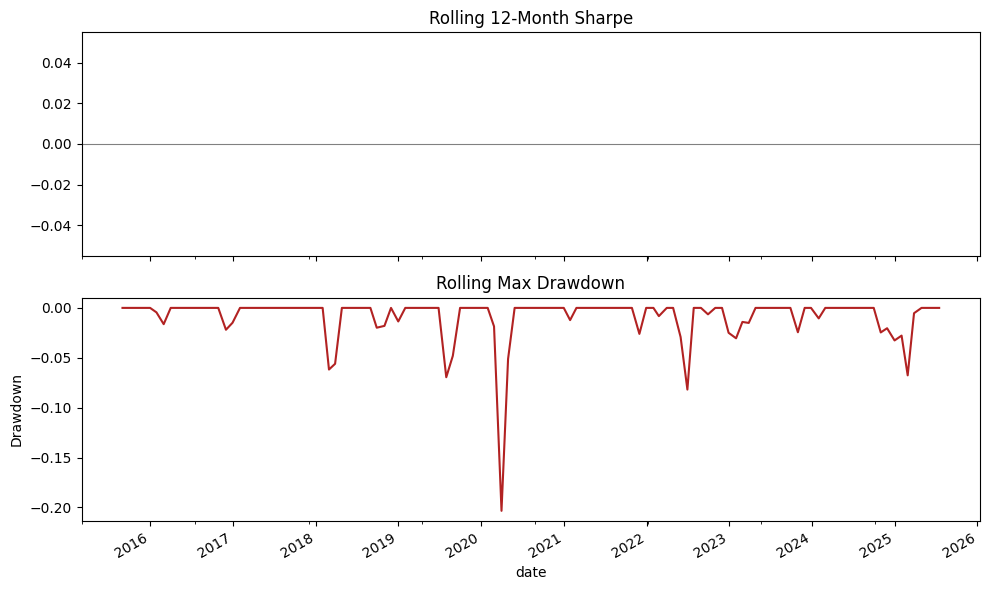

In [27]:
ann_ret = port['ret'].mean()*12
ann_vol = port['ret'].std()*np.sqrt(12)
sharpe  = ann_ret/ann_vol
max_dd  = (port['nav']/port['nav'].cummax()-1).min()

print(f"\n=== Net of {BARCOST_BPS} bp trading cost ===")
print(f"Annualised return   : {ann_ret:.2%}")
print(f"Annualised volatility: {ann_vol:.2%}")
print(f"Sharpe ratio        : {sharpe:.2f}")
print(f"Max drawdown        : {max_dd:.2%}")

port['roll_sharpe'] = (
    port['ret']
      .rolling(252)
      .apply(lambda x:(x.mean()*252)/(x.std()*np.sqrt(252)), raw=True)
)
port['drawdown'] = port['nav']/port['nav'].cummax() - 1

fig, ax = plt.subplots(2,1,figsize=(10,6),sharex=True)
port['roll_sharpe'].plot(ax=ax[0],color='steelblue')
ax[0].set_title('Rolling 12-Month Sharpe'); ax[0].axhline(0,color='grey',lw=0.8)
port['drawdown'].plot(ax=ax[1],color='firebrick')
ax[1].set_title('Rolling Max Drawdown'); ax[1].set_ylabel('Drawdown')
plt.tight_layout(); plt.show()

,date,ticker,weight
0,2025-07-16,HCLTECH.NS,1.000147e-01
1,2025-07-16,ULTRACEMCO.NS,9.999938e-02
2,2025-07-16,BHARTIARTL.NS,9.999930e-02
3,2025-07-16,BAJFINANCE.NS,9.999930e-02
4,2025-07-16,DIVISLAB.NS,9.999929e-02
5,2025-07-16,RELIANCE.NS,9.999928e-02
6,2025-07-16,HINDUNILVR.NS,9.999922e-02
7,2025-07-16,TITAN.NS,9.999912e-02
8,2025-07-16,MARUTI.NS,9.999872e-02
9,2025-07-16,NESTLEIND.NS,9.999074e-02


from matplotlib import pyplot as plt
_df_0['weight'].plot(kind='hist', bins=20, title='weight')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['weight']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('weight')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_3['weight'].plot(kind='line', figsize=(8, 4), title='weight')
plt.gca().spines[['top', 'right']].set_visible(False)

ERROR:root:Did not find quickchart key chart-a3277e3a-559e-4824-a9cf-37ef10c66f69 in chart cache
ERROR:root:Did not find quickchart key chart-6092481c-4904-4e03-b724-75bff849b87d in chart cache


In [3]:
#!mkdir -p /content/nifty50_project && cd /content/nifty50_project

In [2]:
%%writefile README.md
# Nifty-50 ML Portfolio Constructor
One-click Colab notebook that builds, back-tests and plots a factor-based
portfolio for the Nifty 50 universe.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)]
(https://colab.research.google.com/github/golk007/Nifty50_ML_Portfolio/blob/main/Nifty50_ML_Portfolio.ipynb)


Writing README.md


In [4]:
%%writefile requirements.txt
pandas
numpy
yfinance
lightgbm
cvxpy

Writing requirements.txt


In [5]:
%%writefile .gitignore
# ignore data caches and Colab checkpoints
data/
*.ipynb_checkpoints/

Writing .gitignore


In [7]:
import shutil, os
for name in uploaded.keys():
    shutil.move(name, f"/content/nifty50_project/{name}")

In [8]:
!sudo apt-get -qq update
!sudo apt-get -qq install -y git
!git config --global user.name  "Piyush Nahata"
!git config --global user.email "piyushnahata006@gmail.com"


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
